In [19]:
import numpy as np
import pickle as pkl
import music21 as m21
from IPython.display import Image
from tqdm import tqdm_notebook
import time
from pythonosc import udp_client, dispatcher, osc_server

In [2]:
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout, TimeDistributed, Reshape, Lambda
from keras.layers import LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
allBach = m21.corpus.search('bach')

In [4]:
len(allBach)

564

In [5]:
s1 = allBach[1].parse()

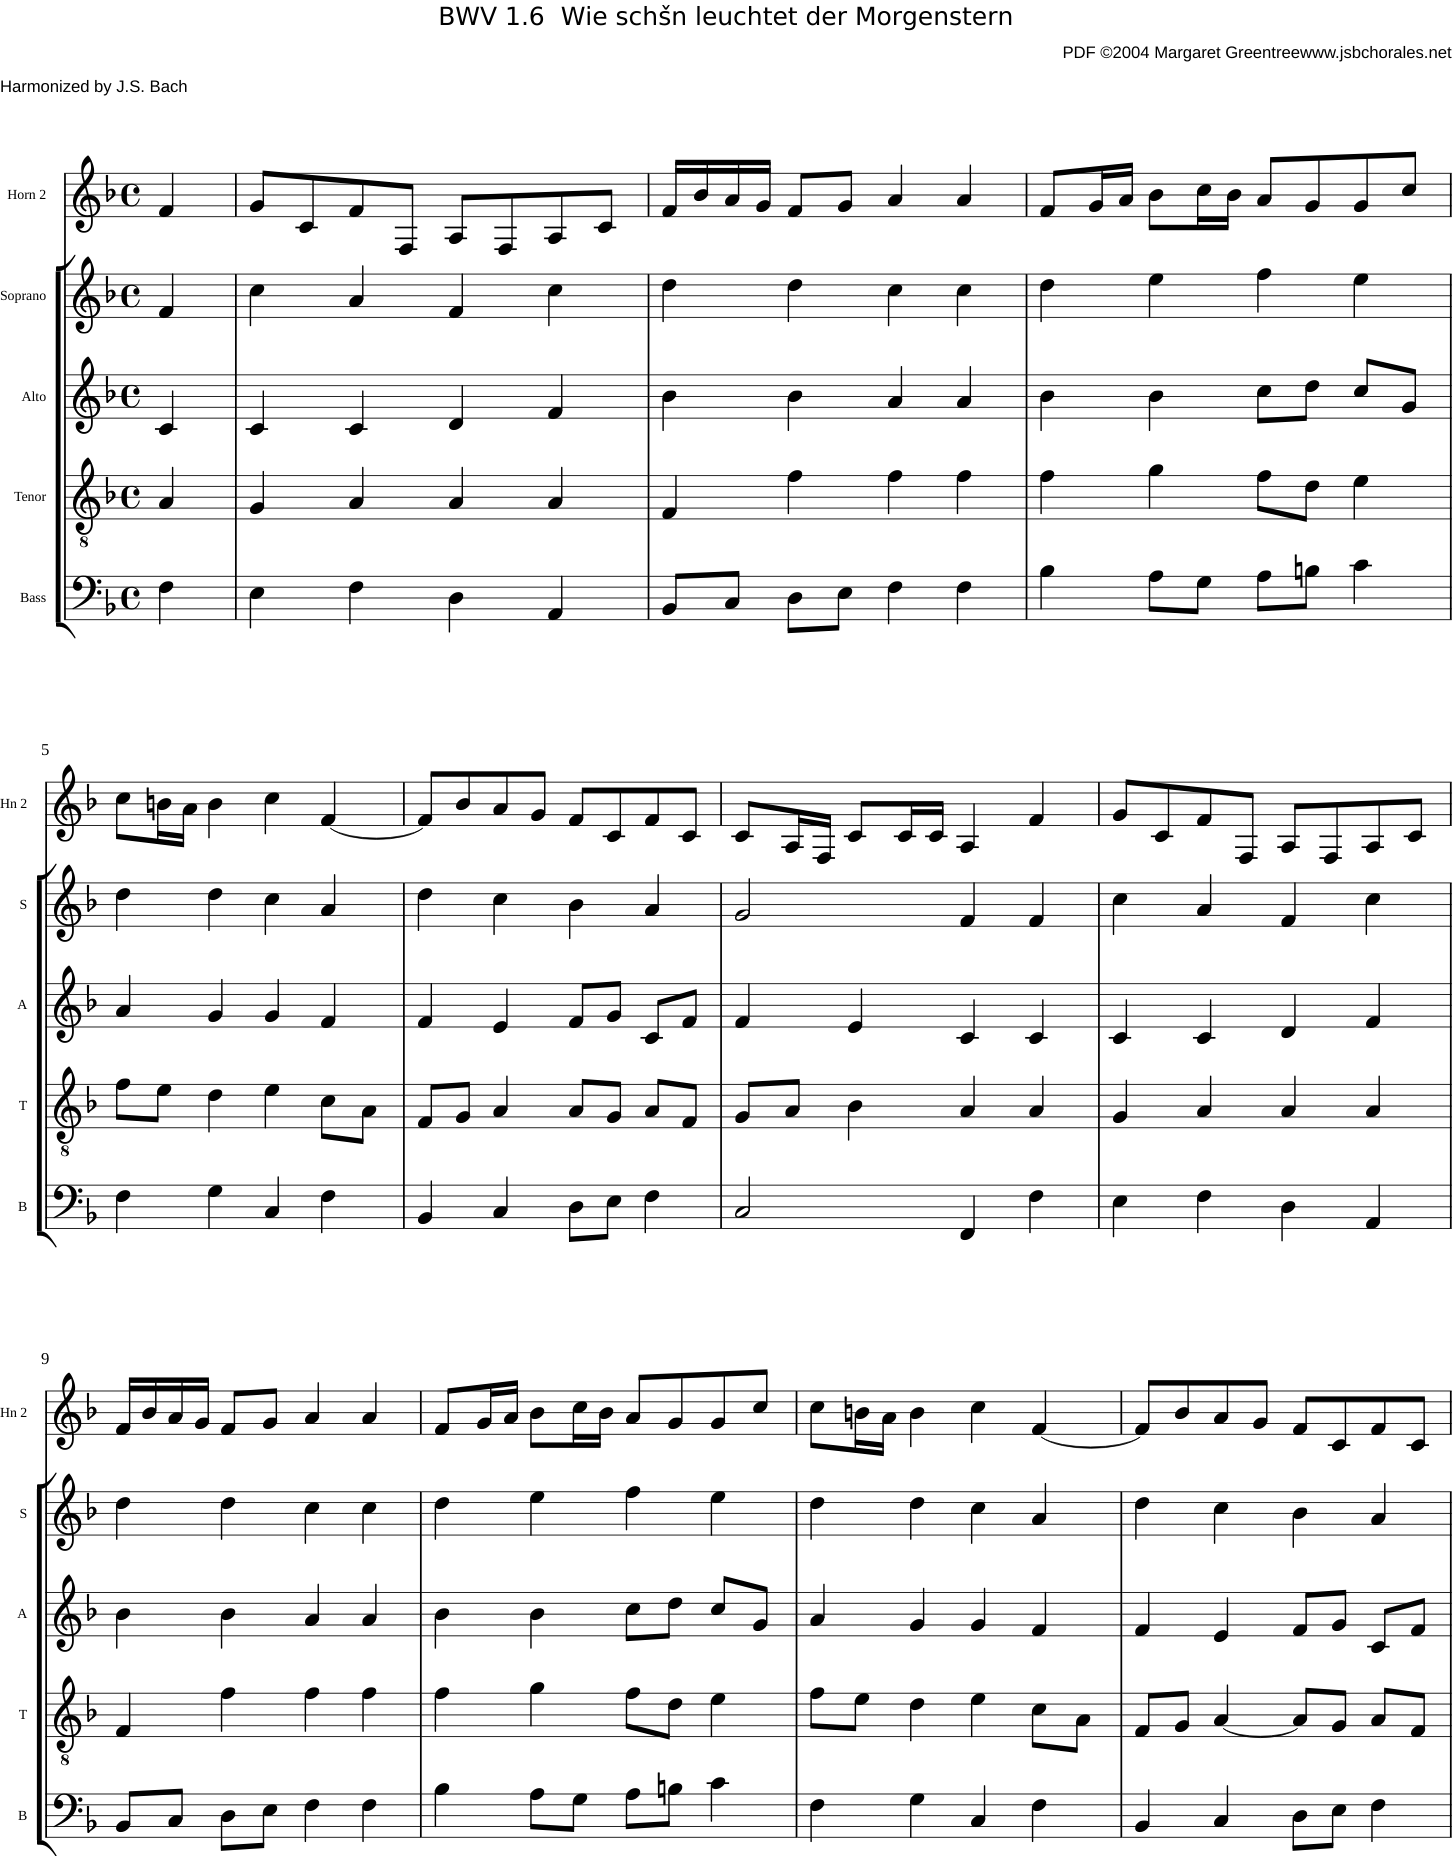

In [6]:
s1.show()

In [82]:
dt = 60 - s1.analyze('key').tonic.midi

In [23]:
''' Load and parse data '''

allBach = m21.corpus.search('bach')
print('Loaded corpus...')
data_all = []
word_to_id = {'EOP': 0}
counter = 1

for piece in tqdm_notebook(allBach):
    score = piece.parse()
    dt = 60 - score.analyze('key').tonic.midi

    for part in score.transpose(dt).parts:
        for x in part.flat.notes:
            if isinstance(x, m21.chord.Chord):
                word = (x.root().midi, x.duration.quarterLength)
            else:
                word = (x.pitch.midi, x.duration.quarterLength)
                
            if word in word_to_id:
                data_all.append(word_to_id[word])
            else:
                word_to_id[word] = counter
                data_all.append(counter)
                counter += 1
        data_all.append(word_to_id['EOP'])
        
print('Parsing Finished!')
    
vocabulary = len(word_to_id)
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))
print('Vocab length: {}\nData Length: {}'.format(vocabulary, len(data_all)))

Loaded corpus...



Parsing Finished!
Vocab length: 541
Data Length: 138142


In [24]:
with open('note_dict.pkl', 'wb') as f:
    pkl.dump(word_to_id, f, pkl.HIGHEST_PROTOCOL)
    
with open('note_data.pkl', 'wb') as f:
    pkl.dump(data_all, f, pkl.HIGHEST_PROTOCOL)

In [ ]:
# pkl.loads()

In [4]:
with open(r'note_dict.pkl', 'rb') as f:
    word_to_id = pkl.load(f)
    
with open('note_data.pkl', 'rb') as f:
    data_all = pkl.load(f)
    
vocabulary = len(word_to_id)
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))

In [9]:
train_data = data_all[:96700]
valid_data = data_all[96700:117420]
train_data2 = data_all[:117420]
test_data = data_all[117420:]

In [10]:
print(''.join(['{} {}\n'.format(*id_to_word[x]) for x in train_data[:10]]))
# training_data

72 1.0
79 1.0
79 0.75
79 0.25
79 1.0
81 1/3
79 1/3
77 1/3
76 1.0
76 0.75



In [11]:
class KerasBatchGenerator(object):
    
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary=  vocabulary
        
        self.current_idx = 0
        self.skip_step = skip_step
        
    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    self.current_idx = 0
                    
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y  = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
                
            yield x, y

In [12]:
num_steps = 30
batch_size = 20

train_data_generator = KerasBatchGenerator(train_data2, num_steps=num_steps, batch_size=batch_size,
                                          vocabulary=vocabulary, skip_step=num_steps)
valid_data_data_generator = KerasBatchGenerator(valid_data, num_steps=num_steps, batch_size=batch_size,
                                          vocabulary=vocabulary, skip_step=num_steps)

In [13]:
hidden_size = 200
use_dropout = True

In [113]:
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))

In [114]:
optimiser = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 200)           108200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 541)           108741    
_________________________________________________________________
activation_3 (Activation)    (None, 30, 541)           0         
Total params: 858,541
Trainable params: 858,541
Non-trainable params: 0
_________________________________________________________________
None

In [115]:
checkpointer = ModelCheckpoint(filepath='./model-{epoch:02d}.hdf5', verbose=1)
num_epochs = 100

In [116]:
# train model
model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,)
#                    validation_data=valid_data_data_generator.generate(),
#                    validation_steps=len(valid_data)//(batch_size*num_steps), callbacks=[checkpointer])
model.save('final_model.hdf5')

Epoch 1/100
161/161 [==============================] - 63s 391ms/step - loss: 4.8648 - categorical_accuracy: 0.0430
Epoch 2/100
161/161 [==============================] - 61s 379ms/step - loss: 4.4815 - categorical_accuracy: 0.0585
Epoch 3/100
161/161 [==============================] - 62s 383ms/step - loss: 3.8872 - categorical_accuracy: 0.1167
Epoch 4/100
161/161 [==============================] - 61s 381ms/step - loss: 3.6296 - categorical_accuracy: 0.1308
Epoch 5/100
161/161 [==============================] - 62s 385ms/step - loss: 3.5249 - categorical_accuracy: 0.1460
Epoch 6/100
161/161 [==============================] - 62s 387ms/step - loss: 3.4141 - categorical_accuracy: 0.1670
Epoch 7/100
161/161 [==============================] - 62s 387ms/step - loss: 3.3669 - categorical_accuracy: 0.1832
Epoch 8/100
161/161 [==============================] - 63s 389ms/step - loss: 3.2500 - categorical_accuracy: 0.1949
Epoch 9/100
161/161 [==============================] - 62s 386ms/step - 

161/161 [==============================] - 56s 349ms/step - loss: 2.3936 - categorical_accuracy: 0.3675
Epoch 72/100
161/161 [==============================] - 56s 350ms/step - loss: 2.4172 - categorical_accuracy: 0.3659
Epoch 73/100
161/161 [==============================] - 56s 350ms/step - loss: 2.3000 - categorical_accuracy: 0.3742
Epoch 74/100
161/161 [==============================] - 56s 347ms/step - loss: 2.2895 - categorical_accuracy: 0.3773
Epoch 75/100
161/161 [==============================] - 56s 350ms/step - loss: 2.3892 - categorical_accuracy: 0.3689
Epoch 76/100
161/161 [==============================] - 56s 347ms/step - loss: 2.3630 - categorical_accuracy: 0.3725
Epoch 77/100
161/161 [==============================] - 57s 356ms/step - loss: 2.3007 - categorical_accuracy: 0.3769
Epoch 78/100
161/161 [==============================] - 57s 351ms/step - loss: 2.2327 - categorical_accuracy: 0.3840
Epoch 79/100
161/161 [==============================] - 56s 350ms/step - loss

In [14]:
model = load_model('./final_model.hdf5')

In [15]:
def parse_notes(notes):
    s = m21.stream.Stream(key='C')
    for val in notes:
        if val == 'EOP':
            continue
        
        d = m21.duration.Duration(val[1])
        s.append(m21.note.Note(val[0], type=d.type))
    
    return s

In [16]:
# test the predictions

test_data_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary, skip_step=1)
num_of_notes = 50

for i in range(150):
    dummy = next(test_data_generator.generate())
    
data = next(test_data_generator.generate())
data = data[0]
print(data.shape)

output = []
for i in range(num_of_notes):
    prediction = model.predict(data)
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    output.append(id_to_word[predict_word])
    data = np.append(data[0][1:], predict_word).reshape((1, 30))

(1, 30)


In [17]:
print(output)

[(48, 1.0), (47, 1.0), (48, 1.0), (43, 1.0), (44, 1.0), (43, 0.5), (41, 0.5), (43, 1.0), (44, 1.0), (38, 1.0), (39, 1.0), (44, 1.0), (43, 1.0), (41, 1.0), (39, 1.0), (38, 1.0), (36, 1.0), (41, 1.0), (43, 1.0), (44, 1.0), (43, 0.5), (41, 0.5), (39, 1.0), (44, 1.0), (46, 1.0), (39, 1.0), (44, 1.0), (43, 1.0), (41, 1.0), (43, 1.0), (36, 1.0), (48, 1.0), (47, 1.0), (48, 1.0), (50, 1.0), (51, 1.0), (50, 1.0), (48, 1.0), (50, 1.0), (51, 1.0), (44, 1.0), (46, 1.0), (39, 1.0), (41, 1.0), (43, 1.0), (44, 1.0), (38, 1.0), (39, 1.0), (44, 1.0), (43, 1.0)]


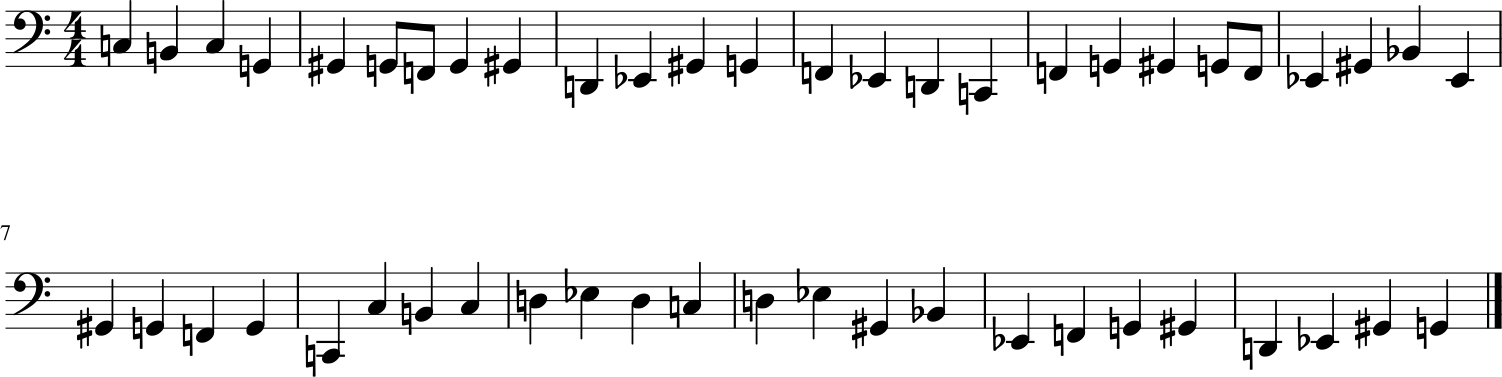

In [18]:
first_song = parse_notes(output)
first_song.show()

In [138]:
mf = m21.midi.translate.streamToMidiFile(first_song)
mf.open('./second.mid', 'wb')
mf.write()
mf.close()

In [20]:
# send notes to synth server
def play(notes, bpm=120):
    client = udp_client.SimpleUDPClient('145.107.37.248', 57120)
    client.send_message("/setup_synth", 0)
    beat = 60 / bpm   # length of a quarter note in seconds
    
    for val in notes:
        if val == 'EOP':
            continue
        
        dur = beat * val[1]
        client.send_message("/play_note", val[0])
        time.sleep(dur)

In [22]:
play(output)

In [26]:
def improvise(model, stimulus, client, bpm=120):
    beat = 60/bpm
    client.send_message("/setup_synth", 0)
    try:
        data = stimulus
        while True:
            prediction = model.predict(data)
            predict_word = np.argmax(prediction[:, num_steps-1, :])
            val = id_to_word[predict_word]
            
            if val == 'EOP':
                continue

            dur = beat * val[1]
            client.send_message("/play_note", val[0])
            time.sleep(dur)
            
            data = np.append(data[0][1:], predict_word).reshape((1, 30))
        
    except KeyboardInterrupt:
        client.send_message("/kill_synths", 0)
        return

In [30]:
test_data_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary, skip_step=1)

for i in range(200):
    dummy = next(test_data_generator.generate())
    
data = next(test_data_generator.generate())
data = data[0]

client = udp_client.SimpleUDPClient('145.107.37.248', 57120)

improvise(model, data, client)